In [2]:
# libraries
# Importing standard Python libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import os # OS operations like file path handling
import re # Regular expressions for text processing
from emoji import demojize # Processing emojis in text
import emoji


# For data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud # To create word cloud visualizations


from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import CLIPTokenizer, CLIPTextModel

from sklearn.model_selection import train_test_split

# Machine learning
from sklearn.linear_model import LogisticRegression

# Deep learning

import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader

# For evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from scipy.sparse import csr_matrix, hstack


/Users/adaeze/anaconda3/envs/pr_ai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-09 01:15:50.412370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

dataset = pd.read_csv('Mental-Health-Twitter.csv')
print(f"Dataset shape: {dataset.shape}")
print(dataset.head())

Dataset shape: (20000, 11)
   Unnamed: 0             post_id                    post_created  \
0           0  637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1           1  637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2           2  637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3           3  637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4           4  637696327485366272  Sat Aug 29 18:40:26 +0000 2015   

                                           post_text     user_id  followers  \
0  It's just over 2 years since I was diagnosed w...  1013187241         84   
1  It's Sunday, I need a break, so I'm planning t...  1013187241         84   
2  Awake but tired. I need to sleep but my brain ...  1013187241         84   
3  RT @SewHQ: #Retro bears make perfect gifts and...  1013187241         84   
4  It’s hard to say whether packing lists are mak...  1013187241         84   

   friends  favourites  statuses  retweets  label  
0      211         251       83

In [5]:
dataset.shape

(20000, 11)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


In [5]:
total_posts = len(dataset)
print(f"Total Posts: {total_posts:,}")

Total Posts: 20,000


In [6]:
unique_users_count = dataset['user_id'].nunique()
print(f"Total Unique Users: {unique_users_count:,}")

Total Unique Users: 72


In [7]:
avg_posts_per_user = total_posts /unique_users_count
print(f"Average Posts per User: {avg_posts_per_user:.2f}")


Average Posts per User: 277.78


Data cleaning

In [8]:
dataset = dataset.replace('?', np.nan)
dataset.isnull().sum()

Unnamed: 0      0
post_id         0
post_created    0
post_text       0
user_id         0
followers       0
friends         0
favourites      0
statuses        0
retweets        0
label           0
dtype: int64

In [9]:
dataset.drop_duplicates(subset='post_text', inplace=True)

In [10]:
# convert post_created to datetime
dataset['post_created'] = pd.to_datetime(dataset['post_created'],
                                        format='%a %b %d %H:%M:%S %z %Y',
                                        errors='coerce')  # Convert invalid dates to NaT

# Check how many failed to convert
print(f"Failed conversions (NaT values): {dataset['post_created'].isna().sum()}")

# Drop rows where conversion failed
dataset = dataset.dropna(subset=['post_created'])


dataset['year'] = dataset['post_created'].dt.year
dataset['month'] = dataset['post_created'].dt.month
dataset['day'] = dataset['post_created'].dt.day
dataset['hour'] = dataset['post_created'].dt.hour



Failed conversions (NaT values): 0


In [11]:
# Drop the original datetime column
dataset_clean = dataset.drop(['post_created'], axis=1, inplace=True)

In [12]:

# Drop rows with missing post_text or post_created
dataset_clean = dataset.dropna(subset=['post_text'])
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'followers', 'friends', 'favourites', 'statuses', 'retweets']
dataset_clean = dataset_clean.drop(columns=[col for col in columns_to_drop if col in dataset_clean.columns])

# Function to clean text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # Remove mentions and hashtags
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply cleaning function to post_text
dataset_clean['clean_text'] = dataset_clean['post_text'].apply(clean_text)


In [13]:
dataset_clean.drop(['post_text'], axis=1, inplace=True)

In [14]:
dataset_clean

,post_id,user_id,label,year,month,day,hour,clean_text
0,637894677824413696,1013187241,1,2015,8,30,7,it's just over 2 years since i was diagnosed w...
1,637890384576778240,1013187241,1,2015,8,30,7,"it's sunday, i need a break, so i'm planning t..."
2,637749345908051968,1013187241,1,2015,8,29,22,awake but tired. i need to sleep but my brain ...
3,637696421077123073,1013187241,1,2015,8,29,18,rt : bears make perfect gifts and are great fo...
4,637696327485366272,1013187241,1,2015,8,29,18,it’s hard to say whether packing lists are mak...
...,...,...,...,...,...,...,...,...
19995,819336825231773698,1169875706,0,2017,1,12,0,a day without sunshine is like night.
19996,819334654260080640,1169875706,0,2017,1,12,0,"boren's laws: (1) when in charge, ponder. (2) ..."
19997,819334503042871297,1169875706,0,2017,1,12,0,the flow chart is a most thoroughly oversold p...
19998,819334419374899200,1169875706,0,2017,1,12,0,"ships are safe in harbor, but they were never ..."


In [ ]:
#  Load Emotion Classifier
# emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [ ]:
# Relableing of dataset Emoji Sentiment Dictionary
# emoji_sentiment = {
#     "😢": -2, "😭": -3, "😞": -2, "😔": -2, "😡": -2,
#     "😃": +2, "😄": +2, "😊": +1, "❤️": +1, "😂": +1,
#     "💔": -2, "😩": -2, "😠": -2, "😕": -1, "🙂": +1
# }
# def score_emojis(text):
#     return sum(emoji_sentiment.get(char, 0) for char in text)

# # STEP 4: Depression Inference Function
# def is_depressive(emotions, emoji_score, emotion_threshold=0.6, emoji_threshold=-2):
#     for emotion in emotions:
#         if emotion["label"] in ["sadness", "fear", "disgust", "anger"] and emotion["score"] >= emotion_threshold:
#             return 1
#     if emoji_score <= emoji_threshold:
#         return 1
#     return 0

# # STEP 5: Apply to Dataset Using 'clean_text'
# def relabel_row(row):
#     text = row["clean_text"]
#     emoji_score = score_emojis(text)
#     emotions = emotion_model(text)[0]
#     return is_depressive(emotions, emoji_score)

# # Create new column for relabelled results
# dataset_clean["depression_label_relabelled"] = dataset_clean.apply(relabel_row, axis=1)

# # Save updated dataset
# dataset_clean.to_csv("depression_dataset_with_relabel.csv", index=False)
# print("Relabelling complete. Sample:\n", dataset_clean[["clean_text", "label", "depression_label_relabelled"]].head())


As an emerging AI technologies and sustainability student trying to create green AI, after relablling orginal dataset, i saved a copy and used it for the rest of my code.

In [15]:
dataset_clean= pd.read_csv('depression_dataset_with_relabel.csv')

In [16]:
dataset_clean

,post_id,user_id,label,year,month,day,hour,clean_text,depression_label_relabelled
0,637894677824413696,1013187241,1,2015,8,30,7,it's just over 2 years since i was diagnosed w...,0
1,637890384576778240,1013187241,1,2015,8,30,7,"it's sunday, i need a break, so i'm planning t...",1
2,637749345908051968,1013187241,1,2015,8,29,22,awake but tired. i need to sleep but my brain ...,1
3,637696421077123073,1013187241,1,2015,8,29,18,rt : bears make perfect gifts and are great fo...,0
4,637696327485366272,1013187241,1,2015,8,29,18,it’s hard to say whether packing lists are mak...,0
...,...,...,...,...,...,...,...,...,...
19483,819336825231773698,1169875706,0,2017,1,12,0,a day without sunshine is like night.,1
19484,819334654260080640,1169875706,0,2017,1,12,0,"boren's laws: (1) when in charge, ponder. (2) ...",0
19485,819334503042871297,1169875706,0,2017,1,12,0,the flow chart is a most thoroughly oversold p...,0
19486,819334419374899200,1169875706,0,2017,1,12,0,"ships are safe in harbor, but they were never ...",0


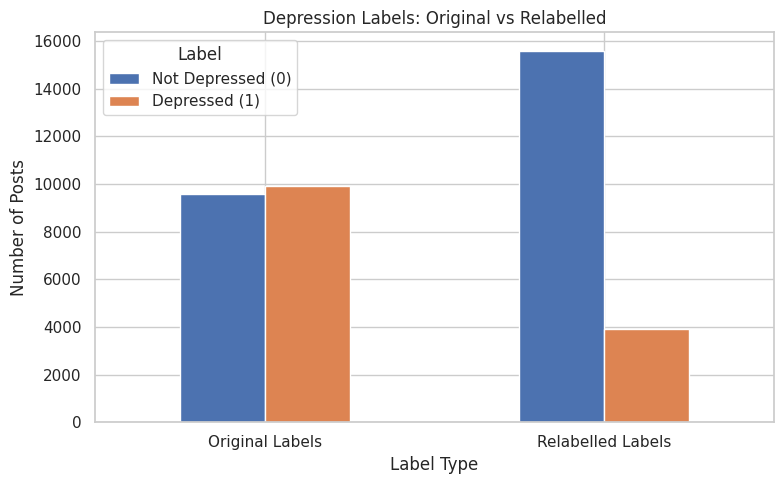

In [ ]:
# Set up plot style
sns.set(style="whitegrid")

# Count values
original_counts = dataset_clean['label'].value_counts().sort_index()
new_counts = dataset_clean['depression_label_relabelled'].value_counts().sort_index()

# Combine into a DataFrame
label_comparison = pd.DataFrame({
    "Original": original_counts,
    "Relabelled": new_counts
}).T

# Bar plot
label_comparison.plot(kind='bar', rot=0, figsize=(8, 5))
plt.title("Depression Labels: Original vs Relabelled")
plt.xlabel("Label Type")
plt.ylabel("Number of Posts")
plt.xticks([0, 1], ['Original Labels', 'Relabelled Labels'])
plt.legend(title='Label', labels=['Not Depressed (0)', 'Depressed (1)'])
plt.tight_layout()
plt.show()

In [17]:
# Check distribution
print(dataset_clean['depression_label_relabelled'].value_counts())


depression_label_relabelled
0    15580
1     3908
Name: count, dtype: int64


In [18]:
# Emoji pattern (broad unicode range)
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U00002600-\U000026FF"  # misc symbols
    "\U0001FA70-\U0001FAFF"  # extended symbols
    "\U00002500-\U00002BEF"  # Chinese symbols sometimes used as emojis
    "]+", flags=re.UNICODE
)

# Extract emojis
def extract_emojis(text):
    return ''.join(emoji_pattern.findall(text))

# Remove emojis
def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

# Apply to your dataset
dataset_clean['emojis'] = dataset_clean['clean_text'].apply(extract_emojis)
dataset_clean['clean_text_no_emoji'] = dataset_clean['clean_text'].apply(remove_emojis)


In [19]:
# Checking that emoji extraction is done
dataset_clean.query('post_id == 637687177946734592')

,post_id,user_id,label,year,month,day,hour,clean_text,depression_label_relabelled,emojis,clean_text_no_emoji
8,637687177946734592,1013187241,1,2015,8,29,18,"can't be bothered to cook, take away on the wa...",1,😁👍🏼,"can't be bothered to cook, take away on the way"


In [20]:
# Translate emojis into words
def demojize_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def simplify_demojized(text):
    # Remove modifiers like skin tone, gender, etc.
    return re.sub(r'_medium_skin_tone|_light_skin_tone|_dark_skin_tone|_man|_woman|_person|_hand|_face', '', text)

def create_clean_text_with_emojis(text):
    return simplify_demojized(demojize_text(text))

# Apply to your base text column (replace with your actual cleaned column name)
dataset_clean['clean_text_with_emojis'] = dataset_clean['clean_text'].apply(create_clean_text_with_emojis)


In [22]:
# Used to build emoji-to-sentiment dictionary
emoji_sentiment = pd.read_csv('Emoji_Sentiment_Data_v1.0.csv')

In [17]:
# Calculate sentiment score manually
def compute_sentiment(row):
    pos = row['Positive']
    neg = row['Negative']
    total = pos + neg
    if total == 0:
        return 'neutral'
    score = (pos - neg) / total
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply to dataframe
emoji_sentiment['sentiment'] = emoji_sentiment.apply(compute_sentiment, axis=1)

# Build emoji-to-sentiment dictionary
emoji_sentiment_dict = dict(zip(emoji_sentiment['Emoji'], emoji_sentiment['sentiment']))

In [18]:
def map_emoji_sentiments(emoji_list):
    return [emoji_sentiment_dict.get(e, 'unknown') for e in emoji_list]

dataset_clean['emoji_sentiments'] = dataset_clean['emojis'].apply(map_emoji_sentiments)


In [19]:
# Function to convert emojis to sentiment using fallback dictionary
def map_emoji_sentiments(emoji_list):
    sentiments = []
    for char in emoji_list:
        for e in char:
            if e in emoji_sentiment_dict:
                sentiments.append(emoji_sentiment_dict[e])
            else:
                sentiments.append('unknown')
    return sentiments

# Apply using the original emojis, now sentiment-aware
dataset_clean['emoji_sentiments'] = dataset_clean['emojis'].apply(map_emoji_sentiments)


In [20]:
def merge_sentiments_into_text(row):
    base_text = row['clean_text_with_emojis']
    sentiments = row['emoji_sentiments']

    if sentiments and isinstance(sentiments, list):
        # Remove unknowns and duplicates
        sentiments_clean = [s for s in sentiments if s != 'unknown']
        if sentiments_clean:
            sentiment_text = ' '.join(set(sentiments_clean))  # remove duplicates
            return f"{base_text} {sentiment_text}"

    # If no useful sentiments, just return the base text
    return base_text

# Create final modeling column
dataset_clean['final_text_for_model'] = dataset_clean.apply(merge_sentiments_into_text, axis=1)

In [ ]:
dataset_clean.query('post_id == 637687177946734592')

,post_id,user_id,label,year,month,day,hour,clean_text,depression_label_relabelled,emojis,clean_text_no_emoji,clean_text_with_emojis,emoji_sentiments,final_text_for_model
8,637687177946734592,1013187241,1,2015,8,29,18,"can't be bothered to cook, take away on the wa...",1,😁👍🏼,"can't be bothered to cook, take away on the way","can't be bothered to cook, take away on the wa...","[positive, positive, unknown]","can't be bothered to cook, take away on the wa..."


In [21]:
# Checking the final_text_for_model post_text for that specific post_id
full_text = dataset_clean.query('post_id == 637687177946734592')['final_text_for_model'].iloc[0]
print(full_text)

can't be bothered to cook, take away on the way  beaming_with_smiling_eyes  thumbs_up_medium-light_skin_tone  positive


Visualize & Analyze the Cleaned Data


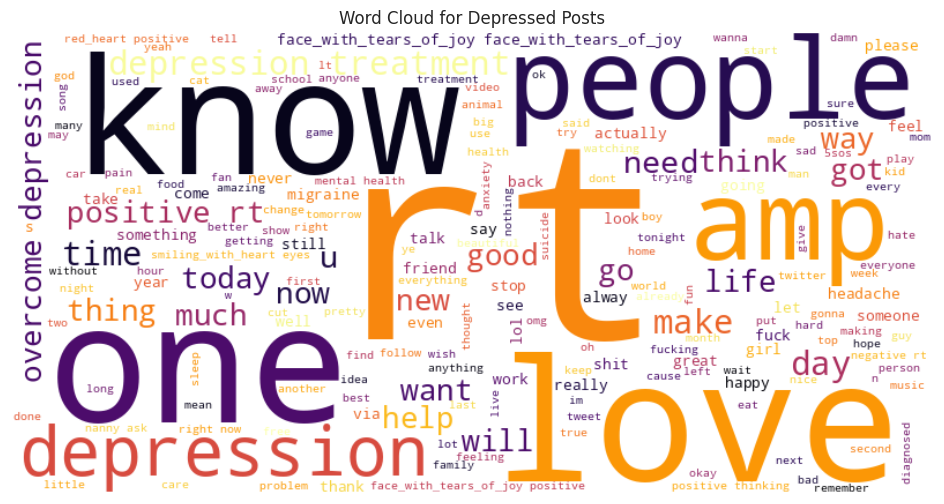

In [ ]:

# Filter depressed posts (label == 1)
depressed_posts = dataset_clean[dataset_clean['label'] == 1]['final_text_for_model']

# Join all text into one string
text = " ".join(depressed_posts.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=200,
    colormap='inferno'
).generate(text)

# Plot it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Depressed Posts")
plt.show()


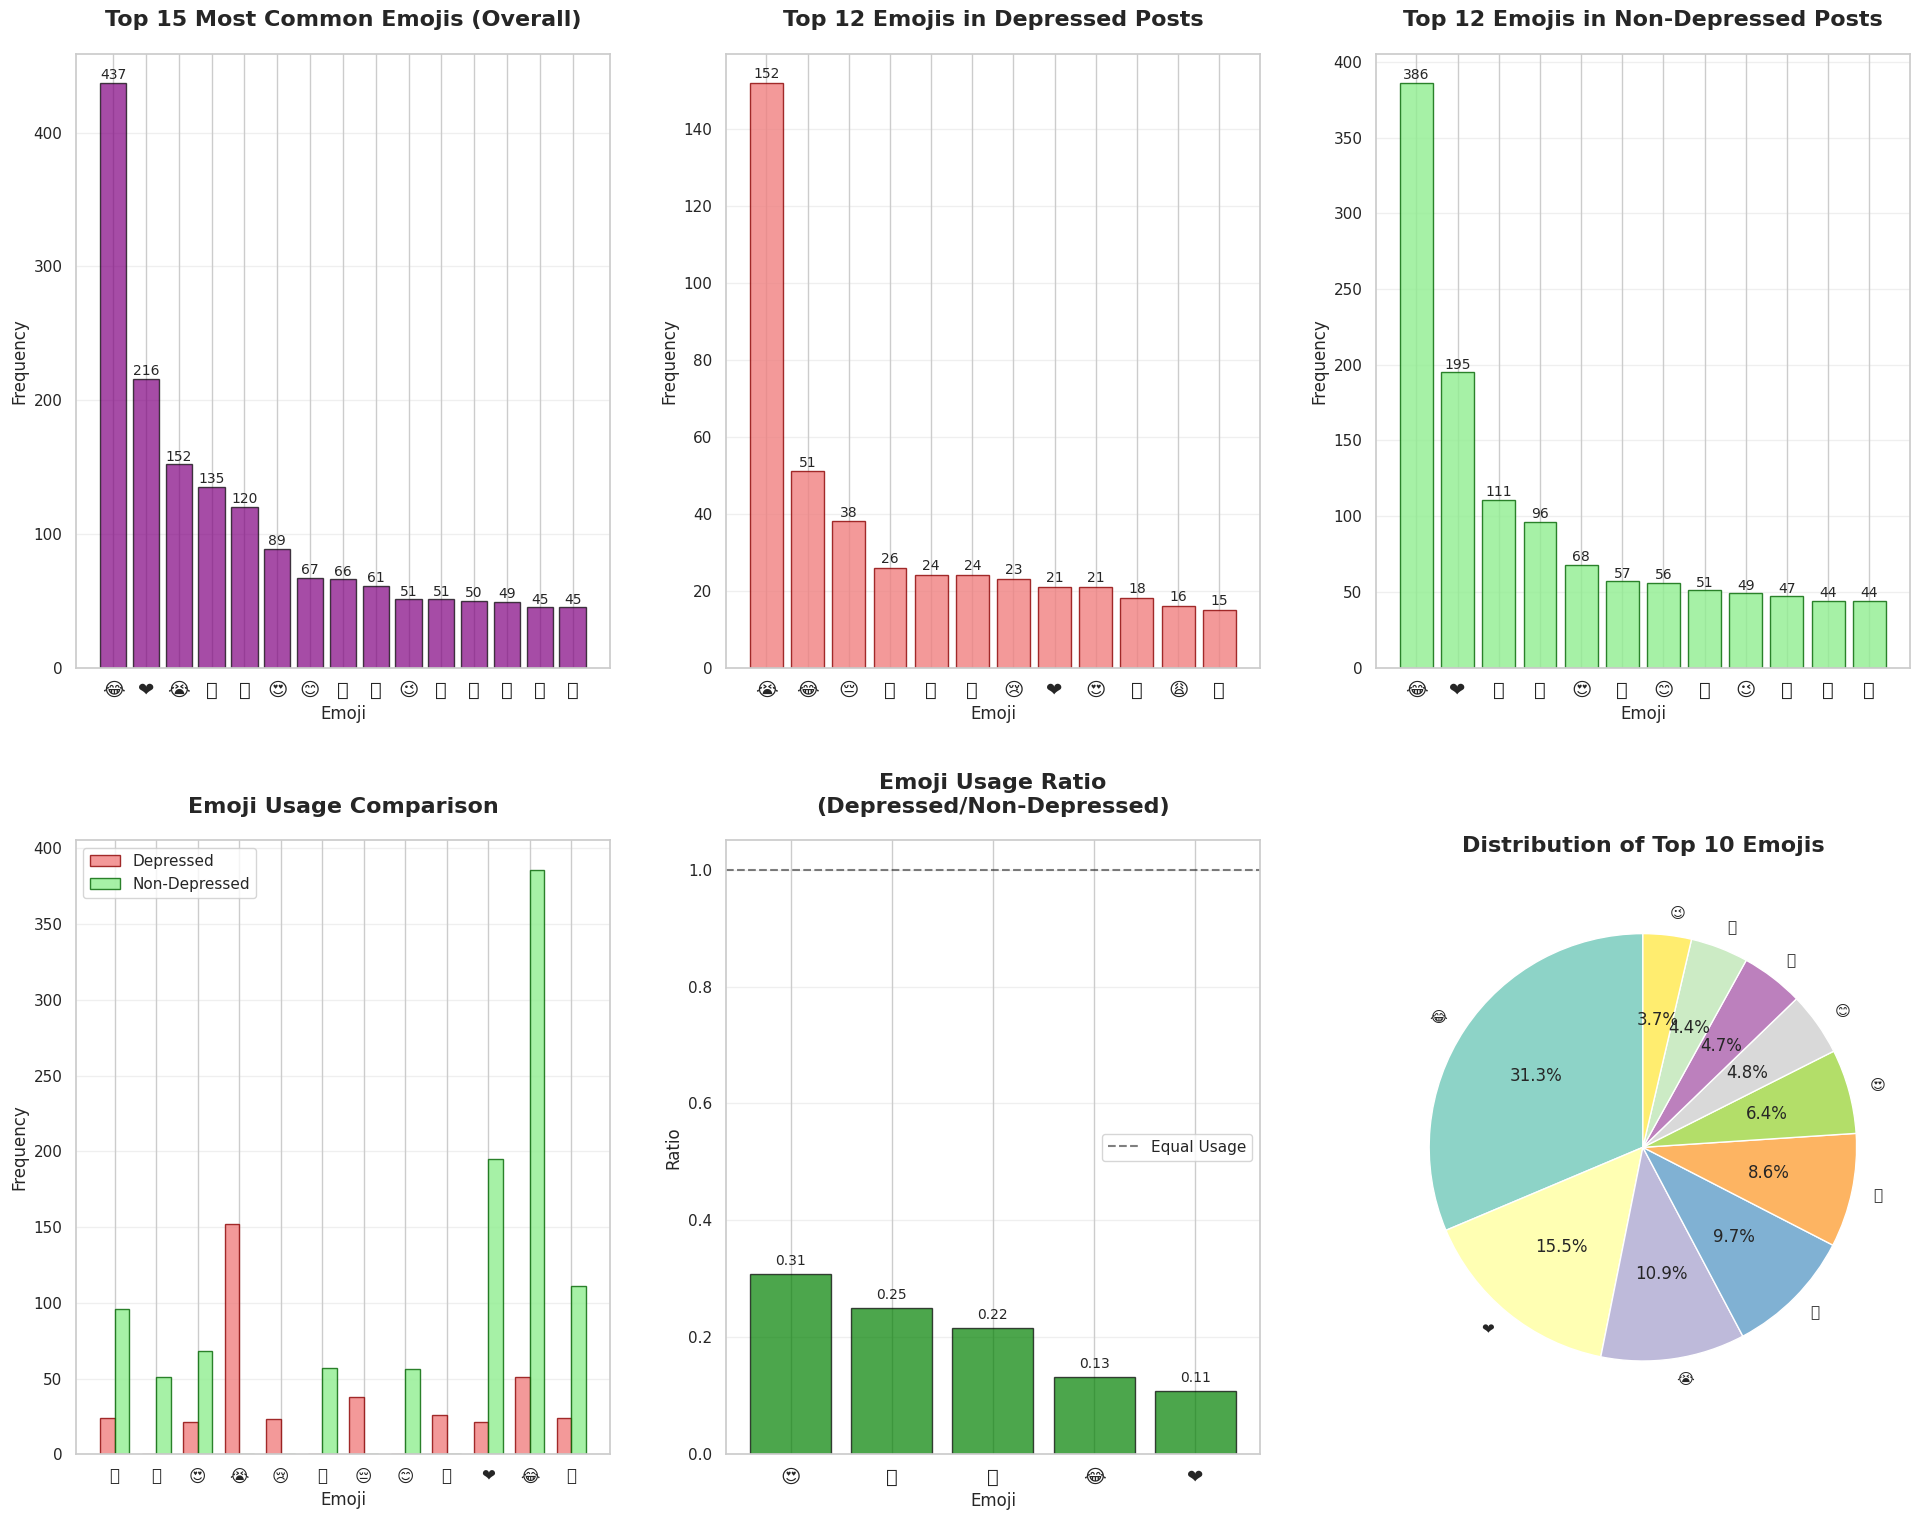

 EMOJI ANALYSIS SUMMARY

 OVERALL STATISTICS:
Total unique emojis: 18257
Total emoji usage: 21186
Depressed posts: 3908 posts
Non-depressed posts: 15580 posts

 TOP 10 OVERALL EMOJIS:
Rank | Emoji | Count
--------------------
   1 | 😂     |   437
   2 | ❤     |   216
   3 | 😭     |   152
   4 | 🇺     |   135
   5 | 🇷     |   120
   6 | 😍     |    89
   7 | 😊     |    67
   8 | 🏻     |    66
   9 | 🙏     |    61
  10 | 😉     |    51

😢 TOP 10 EMOJIS IN DEPRESSED POSTS:
Rank | Emoji | Count
--------------------
   1 | 😭     |   152
   2 | 😂     |    51
   3 | 😔     |    38
   4 | 🏴     |    26
   5 | 🇺     |    24
   6 | 🇷     |    24
   7 | 😢     |    23
   8 | ❤     |    21
   9 | 😍     |    21
  10 | 💔     |    18

😊 TOP 10 EMOJIS IN NON-DEPRESSED POSTS:
Rank | Emoji | Count
--------------------
   1 | 😂     |   386
   2 | ❤     |   195
   3 | 🇺     |   111
   4 | 🇷     |    96
   5 | 😍     |    68
   6 | 🙏     |    57
   7 | 😊     |    56
   8 | 🏻     |    51
   9 | 😉     |    49
  1

In [ ]:


# Function to split emojis (assuming you have this)
def split_emojis(emoji_str):
    return list(str(emoji_str)) if pd.notnull(emoji_str) else []

# Separate depressed and not depressed posts
depressed = dataset_clean[dataset_clean['depression_label_relabelled'] == 1]
not_depressed = dataset_clean[dataset_clean['depression_label_relabelled'] == 0]

# Extract and count emojis for each group
depressed_emojis = depressed['emojis'].dropna().apply(split_emojis).explode()
not_depressed_emojis = not_depressed['emojis'].dropna().apply(split_emojis).explode()

# Get top emojis for each group
top_depressed = Counter(depressed_emojis).most_common(15)
top_not_depressed = Counter(not_depressed_emojis).most_common(15)

# Overall top emojis (combined)
all_emojis = pd.concat([depressed_emojis, not_depressed_emojis])
top_overall = Counter(all_emojis).most_common(20)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# Overall Most Common Emojis
plt.subplot(2, 3, 1)
overall_emojis = [item[0] for item in top_overall[:15]]
overall_counts = [item[1] for item in top_overall[:15]]

bars = plt.bar(range(len(overall_emojis)), overall_counts,
               color='purple', alpha=0.7, edgecolor='black')
plt.title('Top 15 Most Common Emojis (Overall)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoji', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(len(overall_emojis)), overall_emojis, fontsize=14)

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)

# Depressed Posts - Top Emojis
plt.subplot(2, 3, 2)
dep_emojis = [item[0] for item in top_depressed[:12]]
dep_counts = [item[1] for item in top_depressed[:12]]

bars = plt.bar(range(len(dep_emojis)), dep_counts,
               color='lightcoral', alpha=0.8, edgecolor='darkred')
plt.title('Top 12 Emojis in Depressed Posts', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoji', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(len(dep_emojis)), dep_emojis, fontsize=14)

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)

# Non-Depressed Posts - Top Emojis
plt.subplot(2, 3, 3)
not_dep_emojis = [item[0] for item in top_not_depressed[:12]]
not_dep_counts = [item[1] for item in top_not_depressed[:12]]

bars = plt.bar(range(len(not_dep_emojis)), not_dep_counts,
               color='lightgreen', alpha=0.8, edgecolor='darkgreen')
plt.title('Top 12 Emojis in Non-Depressed Posts', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoji', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(len(not_dep_emojis)), not_dep_emojis, fontsize=14)

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)

# Side-by-side comparison of top 10 emojis
plt.subplot(2, 3, 4)

# Get common emojis for comparison
dep_dict = dict(top_depressed[:10])
not_dep_dict = dict(top_not_depressed[:10])

# Find common emojis
common_emojis = set(dep_dict.keys()) & set(not_dep_dict.keys())
all_comparison_emojis = list(set(list(dep_dict.keys())[:8] + list(not_dep_dict.keys())[:8]))

dep_comparison = [dep_dict.get(emoji, 0) for emoji in all_comparison_emojis]
not_dep_comparison = [not_dep_dict.get(emoji, 0) for emoji in all_comparison_emojis]

x = np.arange(len(all_comparison_emojis))
width = 0.35

plt.bar(x - width/2, dep_comparison, width, label='Depressed',
        color='lightcoral', alpha=0.8, edgecolor='darkred')
plt.bar(x + width/2, not_dep_comparison, width, label='Non-Depressed',
        color='lightgreen', alpha=0.8, edgecolor='darkgreen')

plt.title('Emoji Usage Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoji', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(x, all_comparison_emojis, fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 5. Emoji Usage Ratio (Depressed/Non-Depressed)
plt.subplot(2, 3, 5)

# Calculate ratios for common emojis
ratios = []
ratio_emojis = []
for emoji in common_emojis:
    if not_dep_dict[emoji] > 0:  # Avoid division by zero
        ratio = dep_dict[emoji] / not_dep_dict[emoji]
        ratios.append(ratio)
        ratio_emojis.append(emoji)

# Sort by ratio
ratio_data = list(zip(ratio_emojis, ratios))
ratio_data.sort(key=lambda x: x[1], reverse=True)

if len(ratio_data) > 8:
    ratio_data = ratio_data[:8]

ratio_emojis_sorted = [item[0] for item in ratio_data]
ratios_sorted = [item[1] for item in ratio_data]

colors = ['red' if r > 1 else 'green' for r in ratios_sorted]
bars = plt.bar(range(len(ratio_emojis_sorted)), ratios_sorted,
               color=colors, alpha=0.7, edgecolor='black')

plt.title('Emoji Usage Ratio\n(Depressed/Non-Depressed)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoji', fontsize=12)
plt.ylabel('Ratio', fontsize=12)
plt.xticks(range(len(ratio_emojis_sorted)), ratio_emojis_sorted, fontsize=14)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal Usage')
plt.legend()

# Add ratio labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)

# 6. Emoji Distribution Pie Chart (Overall Top 10)
plt.subplot(2, 3, 6)

top_10_overall = top_overall[:10]
pie_labels = [f"{emoji} ({count})" for emoji, count in top_10_overall]
pie_counts = [count for emoji, count in top_10_overall]

colors = plt.cm.Set3(np.linspace(0, 1, len(pie_counts)))
plt.pie(pie_counts, labels=[emoji for emoji, count in top_10_overall],
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Top 10 Emojis', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout(pad=3.0)
plt.show()

# Print detailed statistics
print("="*60)
print(" EMOJI ANALYSIS SUMMARY")
print("="*60)

print(f"\n OVERALL STATISTICS:")
print(f"Total unique emojis: {len(set(all_emojis))}")
print(f"Total emoji usage: {len(all_emojis)}")
print(f"Depressed posts: {len(depressed)} posts")
print(f"Non-depressed posts: {len(not_depressed)} posts")

print(f"\n TOP 10 OVERALL EMOJIS:")
print("Rank | Emoji | Count")
print("-" * 20)
for i, (emoji, count) in enumerate(top_overall[:10], 1):
    print(f"{i:4d} | {emoji:5s} | {count:5d}")

print(f"\n😢 TOP 10 EMOJIS IN DEPRESSED POSTS:")
print("Rank | Emoji | Count")
print("-" * 20)
for i, (emoji, count) in enumerate(top_depressed[:10], 1):
    print(f"{i:4d} | {emoji:5s} | {count:5d}")

print(f"\n😊 TOP 10 EMOJIS IN NON-DEPRESSED POSTS:")
print("Rank | Emoji | Count")
print("-" * 20)
for i, (emoji, count) in enumerate(top_not_depressed[:10], 1):
    print(f"{i:4d} | {emoji:5s} | {count:5d}")

# Unique emojis analysis
dep_set = set([item[0] for item in top_depressed])
not_dep_set = set([item[0] for item in top_not_depressed])

print(f"\n🔍 UNIQUE EMOJI ANALYSIS:")
print(f"Emojis unique to depressed posts: {dep_set - not_dep_set}")
print(f"Emojis unique to non-depressed posts: {not_dep_set - dep_set}")
print(f"Common emojis in both: {dep_set & not_dep_set}")

# Calculate total emoji usage
total_dep_emojis = sum([count for _, count in top_depressed])
total_not_dep_emojis = sum([count for _, count in top_not_depressed])

print(f"\n📊 USAGE TOTALS:")
print(f"Total emoji count in depressed posts: {total_dep_emojis}")
print(f"Total emoji count in non-depressed posts: {total_not_dep_emojis}")
print(f"Average emojis per depressed post: {total_dep_emojis/len(depressed):.2f}")
print(f"Average emojis per non-depressed post: {total_not_dep_emojis/len(not_depressed):.2f}")

Text tokenization

In [22]:
# Load tokenizer and text model from Hugging Face
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Baseline model: LogisticRegression (Individual and Longitudinal tweets, text-only)


RUNNING BASELINE MODELS WITH BALANCED SUBSAMPLING
 BASELINE 1: Individual tweets with balanced subsampling
 Original Dataset Info:
Total samples: 19488
Depression cases: 3908 (20.1%)
Non-depression cases: 15580 (79.9%)

⚖️ Using Balanced Subsampling...
Balanced dataset size: 7816
Depression cases: 3908 (50.0%)
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

 Results:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       782
           1       0.72      0.68      0.70       782

    accuracy                           0.71      1564
   macro avg       0.71      0.71      0.71      1564
weighted avg       0.71      0.71      0.71      1564



<Figure size 800x600 with 0 Axes>

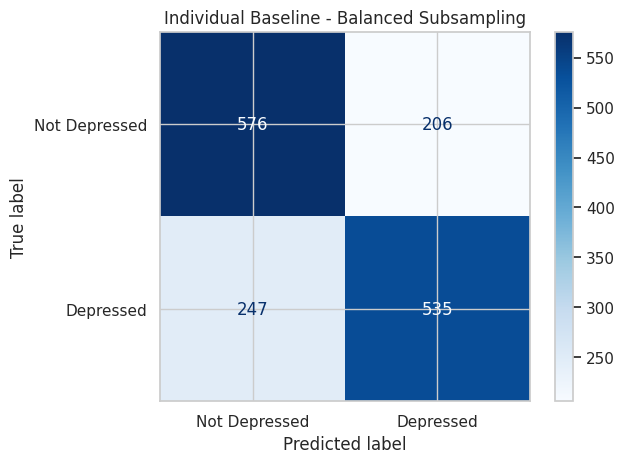

🔍 BASELINE 2: Longitudinal with balanced subsampling

 Creating improved longitudinal sequences...
Posts per sequence: 3-8
Created 115173 improved longitudinal sequences
 Original Longitudinal Dataset Info:
Total sequences: 115173
Depression sequences: 8231 (7.1%)
Average posts per sequence: 5.5

 Creating improved sequence features...
Combined features shape: (115173, 3005)

⚖️ Using Balanced Subsampling for sequences...
Balanced sequences: 16462
Depression sequences: 8231 (50.0%)

 Results:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1647
           1       0.86      0.86      0.86      1646

    accuracy                           0.86      3293
   macro avg       0.86      0.86      0.86      3293
weighted avg       0.86      0.86      0.86      3293



<Figure size 800x600 with 0 Axes>

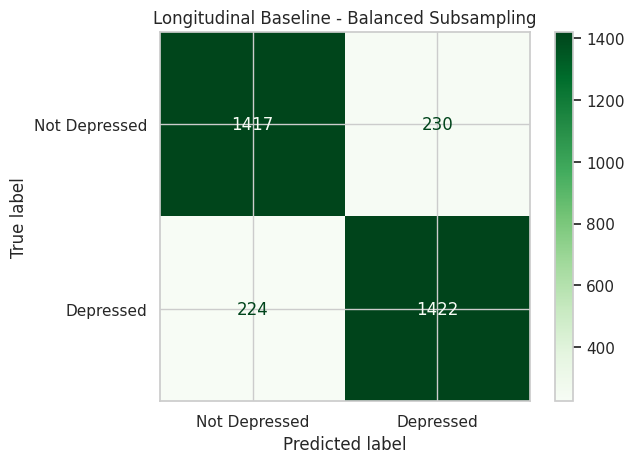


FINAL COMPARISON

RESULTS:
Individual   - Acc: 0.710, F1: 0.703, Prec: 0.722, Rec: 0.684
Longitudinal - Acc: 0.862, F1: 0.862, Prec: 0.861, Rec: 0.864
Improvement  - Acc: +0.152, F1: +0.160


In [ ]:
# BASELINE 1: LogisticRegression (Individual tweets, text-only)

def create_improved_individual_baseline(dataset_clean):
    """
    Individual baseline with balanced subsampling
    """
    print("="*60)
    print(" BASELINE 1: Individual tweets with balanced subsampling")
    print("="*60)

    # Use clean text without emojis
    text_data = dataset_clean['clean_text_no_emoji'].fillna('').tolist()
    y = dataset_clean['depression_label_relabelled'].values

    print(f" Original Dataset Info:")
    print(f"Total samples: {len(text_data)}")
    print(f"Depression cases: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
    print(f"Non-depression cases: {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.1f}%)")

    # Create TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=2,
        max_df=0.95,
        stop_words='english',
        ngram_range=(1, 2),
        lowercase=True,
        strip_accents='unicode'
    )

    X_tfidf = tfidf_vectorizer.fit_transform(text_data)

    # Balanced Subsampling
    print(f"\n⚖️ Using Balanced Subsampling...")

    # Calculate balanced subsample size
    min_class_size = min(sum(y), len(y) - sum(y))
    target_size = min_class_size * 2  # Equal representation

    # Separate classes
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    # Sample equal amounts
    np.random.seed(42)
    pos_sample = np.random.choice(pos_indices, min_class_size, replace=False)
    neg_sample = np.random.choice(neg_indices, min_class_size, replace=False)

    # Combine samples
    balanced_indices = np.concatenate([pos_sample, neg_sample])
    np.random.shuffle(balanced_indices)

    # Handle sparse matrix indexing properly
    from scipy.sparse import csr_matrix
    if hasattr(X_tfidf, 'toarray'):
        # Convert to CSR format for proper indexing
        X_tfidf_csr = csr_matrix(X_tfidf)
        X_balanced = X_tfidf_csr[balanced_indices]
    else:
        X_balanced = X_tfidf[balanced_indices]
    y_balanced = y[balanced_indices]

    print(f"Balanced dataset size: {len(y_balanced)}")
    print(f"Depression cases: {sum(y_balanced)} ({sum(y_balanced)/len(y_balanced)*100:.1f}%)")

    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
    )

    # Compute custom class weights
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    print(f"Class weights: {class_weight_dict}")

    # Train LogisticRegression with custom weights
    from sklearn.linear_model import LogisticRegression
    clf_improved = LogisticRegression(
        class_weight=class_weight_dict,
        max_iter=2000,
        random_state=42,
        C=1.0  # Regularization parameter
    )
    clf_improved.fit(X_train, y_train)

    # Predictions
    y_pred = clf_improved.predict(X_test)
    y_pred_proba = clf_improved.predict_proba(X_test)[:, 1]

    # Metrics
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    print(f"\n Results:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=["Not Depressed", "Depressed"]
    )

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title('Individual Baseline - Balanced Subsampling')
    plt.show()

    return {
        'model': clf_improved,
        'vectorizer': tfidf_vectorizer,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'conf_mat': conf_mat
    }

def create_improved_longitudinal_baseline(dataset_clean):
    """
    Longitudinal baseline with balanced subsampling and better sequence creation
    """
    print("="*60)
    print("🔍 BASELINE 2: Longitudinal with balanced subsampling")
    print("="*60)

    # Create better longitudinal sequences
    sequences, labels, sequence_info = create_better_longitudinal_sequences(dataset_clean)

    if len(sequences) == 0:
        print("No sequences created. Check your data structure.")
        return None

    y = np.array(labels)

    print(f" Original Longitudinal Dataset Info:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Depression sequences: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
    print(f"Average posts per sequence: {np.mean([info['post_count'] for info in sequence_info]):.1f}")

    # Create features using statistical aggregation
    print(f"\n Creating improved sequence features...")

    # TF-IDF on concatenated sequences
    tfidf_vectorizer = TfidfVectorizer(
        max_features=3000,  # Reduced for longitudinal
        min_df=2,
        max_df=0.95,
        stop_words='english',
        ngram_range=(1, 2),
        lowercase=True,
        strip_accents='unicode'
    )

    X_tfidf = tfidf_vectorizer.fit_transform(sequences)

    # Add statistical features
    statistical_features = []
    for info in sequence_info:
        features = [
            info['post_count'],
            info['avg_post_length'],
            info['time_span_hours'],
            info['total_chars'],
            info['unique_words']
        ]
        statistical_features.append(features)

    statistical_features = np.array(statistical_features)

    # Combine TF-IDF and statistical features
    from scipy.sparse import hstack
    X_combined = hstack([X_tfidf, statistical_features])

    print(f"Combined features shape: {X_combined.shape}")

    # Balanced Subsampling for sequences
    print(f"\n⚖️ Using Balanced Subsampling for sequences...")

    min_class_size = min(sum(y), len(y) - sum(y))
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    np.random.seed(42)
    pos_sample = np.random.choice(pos_indices, min_class_size, replace=False)
    neg_sample = np.random.choice(neg_indices, min_class_size, replace=False)

    balanced_indices = np.concatenate([pos_sample, neg_sample])
    np.random.shuffle(balanced_indices)

    # Handle sparse matrix indexing properly
    from scipy.sparse import csr_matrix
    if hasattr(X_combined, 'toarray'):
        # Convert to CSR format for proper indexing
        X_combined_csr = csr_matrix(X_combined)
        X_balanced = X_combined_csr[balanced_indices]
    else:
        X_balanced = X_combined[balanced_indices]
    y_balanced = y[balanced_indices]

    print(f"Balanced sequences: {len(y_balanced)}")
    print(f"Depression sequences: {sum(y_balanced)} ({sum(y_balanced)/len(y_balanced)*100:.1f}%)")

    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
    )

    # Compute class weights
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # Train improved longitudinal model
    from sklearn.linear_model import LogisticRegression
    clf_long_improved = LogisticRegression(
        class_weight=class_weight_dict,
        max_iter=2000,
        random_state=42,
        C=0.5  # Slightly more regularization for longitudinal
    )
    clf_long_improved.fit(X_train, y_train)

    # Predictions
    y_pred = clf_long_improved.predict(X_test)

    # Metrics
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    print(f"\n Results:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=["Not Depressed", "Depressed"]
    )

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Greens')
    plt.title('Longitudinal Baseline - Balanced Subsampling')
    plt.show()

    return {
        'model': clf_long_improved,
        'vectorizer': tfidf_vectorizer,
        'y_test': y_test,
        'y_pred': y_pred,
        'conf_mat': conf_mat
    }

def create_better_longitudinal_sequences(dataset_clean, min_posts=3, max_posts=8):
    """
    Create better longitudinal sequences with more metadata
    """
    print(f"\n Creating improved longitudinal sequences...")
    print(f"Posts per sequence: {min_posts}-{max_posts}")

    # Convert date columns to datetime
    import pandas as pd
    dataset_clean['date'] = pd.to_datetime(
        dataset_clean[['year', 'month', 'day', 'hour']]
    )

    # Sort by user and date
    dataset_clean = dataset_clean.sort_values(['user_id', 'date'])

    sequences = []
    labels = []
    sequence_info = []

    for user_id in dataset_clean['user_id'].unique():
        user_data = dataset_clean[dataset_clean['user_id'] == user_id].copy()

        if len(user_data) < min_posts:
            continue

        # Take sequences of varying lengths
        for seq_len in range(min_posts, min(max_posts + 1, len(user_data) + 1)):
            for i in range(len(user_data) - seq_len + 1):
                window_data = user_data.iloc[i:i+seq_len]

                # Create sequence text
                texts = window_data['clean_text_no_emoji'].fillna('').tolist()
                sequence_text = ' '.join(texts)

                # Use majority vote for label (or most recent)
                depression_votes = window_data['depression_label_relabelled'].sum()
                sequence_label = 1 if depression_votes > seq_len // 2 else 0

                # Calculate sequence metadata
                time_span = (window_data['date'].max() - window_data['date'].min()).total_seconds() / 3600  # hours
                avg_post_length = np.mean([len(text) for text in texts])
                total_chars = len(sequence_text)
                unique_words = len(set(sequence_text.lower().split()))

                sequences.append(sequence_text)
                labels.append(sequence_label)
                sequence_info.append({
                    'user_id': user_id,
                    'post_count': seq_len,
                    'time_span_hours': time_span,
                    'avg_post_length': avg_post_length,
                    'total_chars': total_chars,
                    'unique_words': unique_words
                })

    print(f"Created {len(sequences)} improved longitudinal sequences")
    return sequences, labels, sequence_info

# USAGE
if __name__ == "__main__":
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    # Run both baselines
    print(f"\n{'='*80}")
    print("RUNNING BASELINE MODELS WITH BALANCED SUBSAMPLING")
    print(f"{'='*80}")

    # Individual baseline
    ind_results = create_improved_individual_baseline(dataset_clean)

    # Longitudinal baseline
    long_results = create_improved_longitudinal_baseline(dataset_clean)

    # Compare results
    if ind_results and long_results:
        print(f"\n{'='*80}")
        print("FINAL COMPARISON")
        print(f"{'='*80}")

        ind_acc = accuracy_score(ind_results['y_test'], ind_results['y_pred'])
        ind_f1 = f1_score(ind_results['y_test'], ind_results['y_pred'])
        ind_prec = precision_score(ind_results['y_test'], ind_results['y_pred'])
        ind_rec = recall_score(ind_results['y_test'], ind_results['y_pred'])

        long_acc = accuracy_score(long_results['y_test'], long_results['y_pred'])
        long_f1 = f1_score(long_results['y_test'], long_results['y_pred'])
        long_prec = precision_score(long_results['y_test'], long_results['y_pred'])
        long_rec = recall_score(long_results['y_test'], long_results['y_pred'])

        print(f"\nRESULTS:")
        print(f"Individual   - Acc: {ind_acc:.3f}, F1: {ind_f1:.3f}, Prec: {ind_prec:.3f}, Rec: {ind_rec:.3f}")
        print(f"Longitudinal - Acc: {long_acc:.3f}, F1: {long_f1:.3f}, Prec: {long_prec:.3f}, Rec: {long_rec:.3f}")
        print(f"Improvement  - Acc: {long_acc-ind_acc:+.3f}, F1: {long_f1-ind_f1:+.3f}")

Transformer Longitudinal text only

TRAINING TRANSFORMER LONGITUDINAL MODEL
🔄 Creating Transformer-optimized sequences...
Created 115173 Transformer sequences
Original Transformer Dataset:
Total sequences: 115173
Depression: 8231 (7.1%)
Non-depression: 106942 (92.9%)
Balanced Transformer Dataset:
Total sequences: 16462
Depression: 8231 (50.0%)
Enhanced vocabulary size: 28053

 Split Info:
Training sequences: 13169
Testing sequences: 3293
Vocabulary size: 28053
Using device: cuda
Model parameters: 8,804,674

 Starting training for 25 epochs...


Epoch 1/25: 100%|██████████| 1098/1098 [00:16<00:00, 67.18it/s, Loss=0.1310, Acc=0.7843]


Epoch 1/25:
  Train Loss: 0.4523, Train Acc: 0.7843
  Val Acc: 0.8882, Val F1: 0.8876
 New best model saved! (Acc: 0.8882)
--------------------------------------------------


Epoch 2/25: 100%|██████████| 1098/1098 [00:15<00:00, 71.13it/s, Loss=1.2143, Acc=0.9150]


Epoch 2/25:
  Train Loss: 0.2400, Train Acc: 0.9150
  Val Acc: 0.8867, Val F1: 0.8810
--------------------------------------------------


Epoch 3/25: 100%|██████████| 1098/1098 [00:15<00:00, 69.39it/s, Loss=0.0034, Acc=0.9434]


Epoch 3/25:
  Train Loss: 0.1757, Train Acc: 0.9434
  Val Acc: 0.9077, Val F1: 0.9107
 New best model saved! (Acc: 0.9077)
--------------------------------------------------


Epoch 4/25: 100%|██████████| 1098/1098 [00:15<00:00, 71.22it/s, Loss=0.0097, Acc=0.9598]


Epoch 4/25:
  Train Loss: 0.1383, Train Acc: 0.9598
  Val Acc: 0.9086, Val F1: 0.9099
 New best model saved! (Acc: 0.9086)
--------------------------------------------------


Epoch 5/25: 100%|██████████| 1098/1098 [00:15<00:00, 70.92it/s, Loss=0.0018, Acc=0.9672]


Epoch 5/25:
  Train Loss: 0.1144, Train Acc: 0.9672
  Val Acc: 0.9101, Val F1: 0.9116
 New best model saved! (Acc: 0.9101)
--------------------------------------------------


Epoch 6/25: 100%|██████████| 1098/1098 [00:15<00:00, 71.17it/s, Loss=0.0334, Acc=0.9743]


Epoch 6/25:
  Train Loss: 0.0910, Train Acc: 0.9743
  Val Acc: 0.9046, Val F1: 0.9051
--------------------------------------------------


Epoch 7/25: 100%|██████████| 1098/1098 [00:15<00:00, 70.89it/s, Loss=0.0008, Acc=0.9796]


Epoch 7/25:
  Train Loss: 0.0776, Train Acc: 0.9796
  Val Acc: 0.8977, Val F1: 0.9019
--------------------------------------------------


Epoch 8/25: 100%|██████████| 1098/1098 [00:15<00:00, 71.06it/s, Loss=1.1615, Acc=0.9834]


Epoch 8/25:
  Train Loss: 0.0587, Train Acc: 0.9834
  Val Acc: 0.8934, Val F1: 0.8983
--------------------------------------------------


Epoch 9/25: 100%|██████████| 1098/1098 [00:15<00:00, 70.79it/s, Loss=0.0017, Acc=0.9860]


Epoch 9/25:
  Train Loss: 0.0496, Train Acc: 0.9860
  Val Acc: 0.8949, Val F1: 0.8991
--------------------------------------------------


Epoch 10/25: 100%|██████████| 1098/1098 [00:15<00:00, 71.30it/s, Loss=0.1355, Acc=0.9888]


Epoch 10/25:
  Train Loss: 0.0430, Train Acc: 0.9888
  Val Acc: 0.8867, Val F1: 0.8921
--------------------------------------------------


Epoch 11/25: 100%|██████████| 1098/1098 [00:15<00:00, 70.86it/s, Loss=0.0002, Acc=0.9912]


Epoch 11/25:
  Train Loss: 0.0346, Train Acc: 0.9912
  Val Acc: 0.8958, Val F1: 0.8965
--------------------------------------------------


Epoch 12/25: 100%|██████████| 1098/1098 [00:15<00:00, 71.33it/s, Loss=0.0000, Acc=0.9945]


Epoch 12/25:
  Train Loss: 0.0212, Train Acc: 0.9945
  Val Acc: 0.8940, Val F1: 0.8947
--------------------------------------------------


Epoch 13/25: 100%|██████████| 1098/1098 [00:15<00:00, 71.38it/s, Loss=0.0000, Acc=0.9968]


Epoch 13/25:
  Train Loss: 0.0129, Train Acc: 0.9968
  Val Acc: 0.8940, Val F1: 0.8976
 Early stopping at epoch 13

 FINAL EVALUATION:
 Transformer Model Results:
Accuracy: 0.9101
F1-Score: 0.9116
Precision: 0.8966
Recall: 0.9271

Detailed Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.92      0.89      0.91      1647
    Depressed       0.90      0.93      0.91      1646

     accuracy                           0.91      3293
    macro avg       0.91      0.91      0.91      3293
 weighted avg       0.91      0.91      0.91      3293



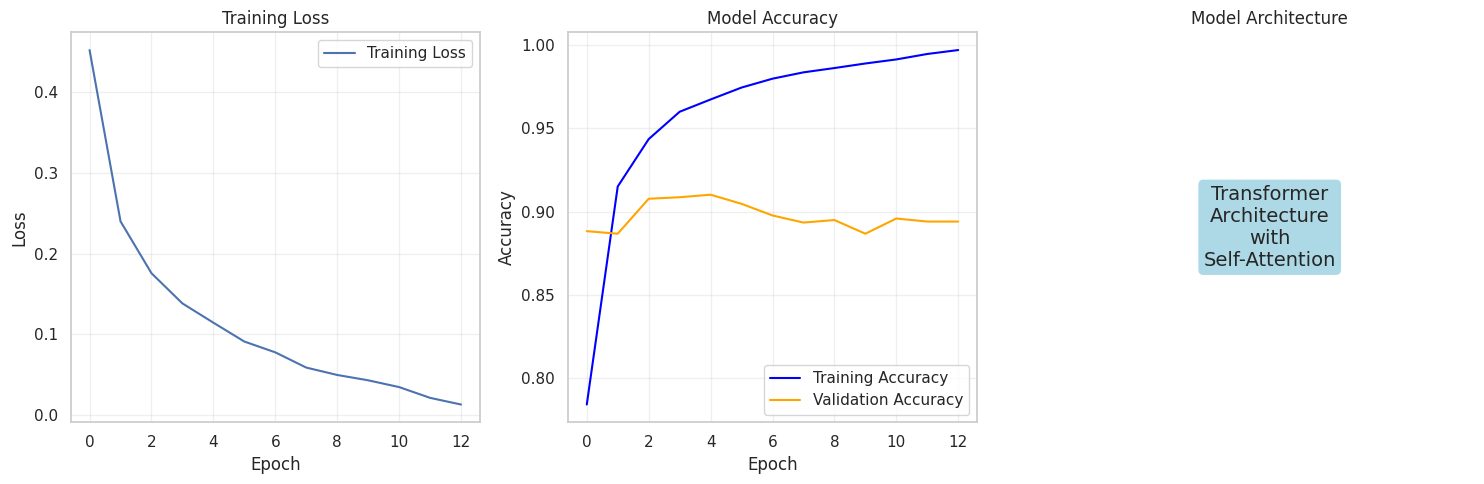

<Figure size 800x600 with 0 Axes>

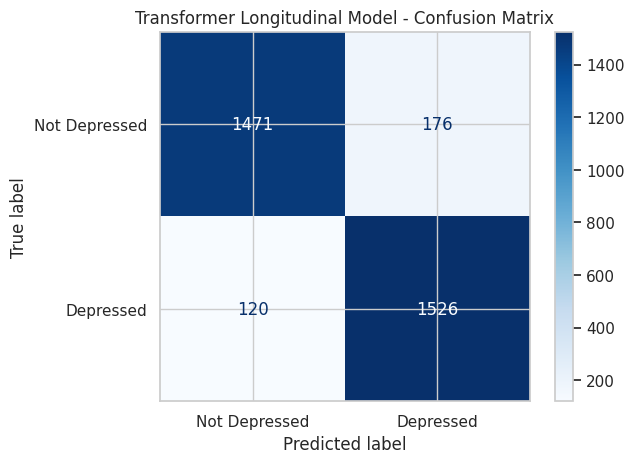


TRANSFORMER vs ALL BASELINES COMPARISON
Individual Baseline      - Acc: 0.710
Longitudinal Baseline    - Acc: 0.862
Transformer (Text-only)  - Acc: 0.910, F1: 0.912

Transformer Improvements:
vs Individual:     +0.200
vs Longitudinal:   +0.048
SUCCESS: Transformer beats all previous models!
 Ready for CLIP multimodal fusion!


In [ ]:


# TRANSFORMER ARCHITECTURE

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDepressionClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3,
                 dim_feedforward=512, dropout=0.2, max_len=200):
        super(TransformerDepressionClassifier, self).__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )

        # Initialize parameters
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                module.weight.data.uniform_(-initrange, initrange)
                module.bias.data.zero_()

    def create_padding_mask(self, x):
        """Create mask for padding tokens"""
        return (x == 0)  # 0 is padding token

    def forward(self, x):
        # x shape: (batch_size, seq_len)

        # Create padding mask
        padding_mask = self.create_padding_mask(x)

        # Embedding and positional encoding
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        embedded = self.pos_encoder(embedded.transpose(0, 1)).transpose(0, 1)

        # Transformer encoding
        encoded = self.transformer_encoder(
            embedded,
            src_key_padding_mask=padding_mask
        )

        # Global average pooling (ignoring padding)
        mask_expanded = (~padding_mask).unsqueeze(-1).float()
        masked_encoded = encoded * mask_expanded
        pooled = masked_encoded.sum(dim=1) / mask_expanded.sum(dim=1)

        # Classification
        output = self.classifier(pooled)

        return output

# ===== DATASET CLASS =====

class TransformerSequenceDataset(Dataset):
    def __init__(self, sequences, labels, word_to_idx, max_length=200):
        self.sequences = sequences
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]

        # Convert words to indices
        words = sequence.lower().split()[:self.max_length]
        indices = [self.word_to_idx.get(word, 1) for word in words]  # 1 = UNK

        # Pad sequence
        while len(indices) < self.max_length:
            indices.append(0)  # 0 = PAD

        return {
            'sequence': torch.tensor(indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

#  HELPER FUNCTIONS

def create_transformer_sequences(dataset_clean, min_posts=3, max_posts=8):
    """
    Create longitudinal sequences optimized for Transformer processing
    """
    print(f"🔄 Creating Transformer-optimized sequences...")

    # Convert date columns to datetime
    dataset_clean['date'] = pd.to_datetime(
        dataset_clean[['year', 'month', 'day', 'hour']]
    )

    # Sort by user and date
    dataset_clean = dataset_clean.sort_values(['user_id', 'date'])

    sequences = []
    labels = []

    for user_id in dataset_clean['user_id'].unique():
        user_data = dataset_clean[dataset_clean['user_id'] == user_id].copy()

        if len(user_data) < min_posts:
            continue

        # Create sequences of varying lengths
        for seq_len in range(min_posts, min(max_posts + 1, len(user_data) + 1)):
            for i in range(len(user_data) - seq_len + 1):
                window_data = user_data.iloc[i:i+seq_len]

                # Create sequence text with special separators for posts
                texts = window_data['clean_text_no_emoji'].fillna('').tolist()
                # Use special tokens to separate posts for better attention
                sequence_text = ' [SEP] '.join(texts)

                # Use majority vote for label
                depression_votes = window_data['depression_label_relabelled'].sum()
                sequence_label = 1 if depression_votes > seq_len // 2 else 0

                sequences.append(sequence_text)
                labels.append(sequence_label)

    print(f"Created {len(sequences)} Transformer sequences")
    return sequences, labels

def create_enhanced_vocabulary(sequences, min_freq=2):
    """
    Create vocabulary with special tokens for Transformer
    """
    word_counts = {}
    for sequence in sequences:
        words = sequence.lower().split()
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

    # Filter by frequency and add special tokens
    vocab = ['<PAD>', '<UNK>', '[SEP]', '<START>', '<END>']  # Special tokens
    for word, count in word_counts.items():
        if count >= min_freq and word not in vocab:
            vocab.append(word)

    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    print(f"Enhanced vocabulary size: {len(vocab)}")
    return word_to_idx, vocab

def balance_transformer_data(sequences, labels):
    """
    Balance dataset using the successful approach
    """
    y = np.array(labels)

    print(f"Original Transformer Dataset:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Depression: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
    print(f"Non-depression: {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.1f}%)")

    # Balanced subsampling
    min_class_size = min(sum(y), len(y) - sum(y))
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    np.random.seed(42)
    pos_sample = np.random.choice(pos_indices, min_class_size, replace=False)
    neg_sample = np.random.choice(neg_indices, min_class_size, replace=False)

    balanced_indices = np.concatenate([pos_sample, neg_sample])
    np.random.shuffle(balanced_indices)

    balanced_sequences = [sequences[i] for i in balanced_indices]
    balanced_labels = [labels[i] for i in balanced_indices]

    print(f"Balanced Transformer Dataset:")
    print(f"Total sequences: {len(balanced_sequences)}")
    print(f"Depression: {sum(balanced_labels)} ({sum(balanced_labels)/len(balanced_labels)*100:.1f}%)")

    return balanced_sequences, balanced_labels

# TRAINING FUNCTION

def train_transformer_model(dataset_clean, epochs=30, batch_size=16, learning_rate=1e-4):
    """
    Train the Transformer model for longitudinal depression detection
    """
    print("="*60)
    print("TRAINING TRANSFORMER LONGITUDINAL MODEL")
    print("="*60)

    # Create sequences
    sequences, labels = create_transformer_sequences(dataset_clean)

    if len(sequences) == 0:
        print("No sequences created!")
        return None

    # Balance the data
    balanced_sequences, balanced_labels = balance_transformer_data(sequences, labels)

    # Create enhanced vocabulary
    word_to_idx, vocab = create_enhanced_vocabulary(balanced_sequences, min_freq=2)
    vocab_size = len(vocab)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        balanced_sequences, balanced_labels,
        test_size=0.2,
        stratify=balanced_labels,
        random_state=42
    )

    print(f"\n Split Info:")
    print(f"Training sequences: {len(X_train)}")
    print(f"Testing sequences: {len(X_test)}")
    print(f"Vocabulary size: {vocab_size}")

    # Create datasets
    train_dataset = TransformerSequenceDataset(X_train, y_train, word_to_idx, max_length=180)
    test_dataset = TransformerSequenceDataset(X_test, y_test, word_to_idx, max_length=180)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = TransformerDepressionClassifier(
        vocab_size=vocab_size,
        d_model=256,
        nhead=8,
        num_layers=3,
        dim_feedforward=512,
        dropout=0.2
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )

    # Training loop
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0
    patience_counter = 0
    patience = 8

    print(f"\n Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch in progress_bar:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{correct_predictions/total_predictions:.4f}'
            })

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_accuracy, val_f1 = evaluate_transformer_model(model, test_loader, device, verbose=False)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"  Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_transformer_depression_model.pth')
            print(f" New best model saved! (Acc: {val_accuracy:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f" Early stopping at epoch {epoch+1}")
                break

        print("-" * 50)

    # Load best model for final evaluation
    model.load_state_dict(torch.load('best_transformer_depression_model.pth'))

    # Final evaluation
    print(f"\n FINAL EVALUATION:")
    final_accuracy, final_f1, predictions, true_labels = evaluate_transformer_model(
        model, test_loader, device, verbose=True, return_predictions=True
    )

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    # Attention visualization placeholder
    plt.text(0.5, 0.5, 'Transformer\nArchitecture\nwith\nSelf-Attention',
             ha='center', va='center', fontsize=14,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.title('Model Architecture')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_mat = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=["Not Depressed", "Depressed"]
    )
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title('Transformer Longitudinal Model - Confusion Matrix')
    plt.show()

    return {
        'model': model,
        'vocab': vocab,
        'word_to_idx': word_to_idx,
        'final_accuracy': final_accuracy,
        'final_f1': final_f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

def evaluate_transformer_model(model, test_loader, device, verbose=True, return_predictions=False):
    """
    Evaluate the Transformer model
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)

            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    if verbose:
        print(f" Transformer Model Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print()
        print("Detailed Classification Report:")
        print(classification_report(all_labels, all_predictions,
                                  target_names=['Not Depressed', 'Depressed']))

    if return_predictions:
        return accuracy, f1, all_predictions, all_labels
    else:
        return accuracy, f1

# USAGE
if __name__ == "__main__":
    # Train Transformer model
    transformer_results = train_transformer_model(
        dataset_clean,
        epochs=25,
        batch_size=12,
        learning_rate=1e-4
    )

    if transformer_results:
        print(f"\n{'='*60}")
        print("TRANSFORMER vs ALL BASELINES COMPARISON")
        print(f"{'='*60}")

        # Compare with all previous models
        individual_baseline = 0.710      # LogisticRegression Individual
        longitudinal_baseline = 0.862    # LogisticRegression Longitudinal


        transformer_accuracy = transformer_results['final_accuracy']
        transformer_f1 = transformer_results['final_f1']

        print(f"Individual Baseline      - Acc: {individual_baseline:.3f}")
        print(f"Longitudinal Baseline    - Acc: {longitudinal_baseline:.3f}")
        print(f"Transformer (Text-only)  - Acc: {transformer_accuracy:.3f}, F1: {transformer_f1:.3f}")

        print(f"\nTransformer Improvements:")
        print(f"vs Individual:     {transformer_accuracy-individual_baseline:+.3f}")
        print(f"vs Longitudinal:   {transformer_accuracy-longitudinal_baseline:+.3f}")


        # if transformer_accuracy > neural_network:
        #     print("SUCCESS: Transformer beats all previous models!")
        #     print(" Ready for CLIP multimodal fusion!")
        # else:
        #     print(" Transformer underperforms. May need hyperparameter tuning.")
        #     print(f"   Current best: Enhanced Neural Network ({neural_network:.3f})")

In [23]:
# Convert text into a list
text_data = dataset_clean['final_text_for_model'].tolist()

# Tokenize the list of texts
tokenized = tokenizer(
    text_data,
    padding=True,
    truncation=True,
    return_tensors="pt"  # PyTorch tensors
)

In [24]:
with torch.no_grad():
    text_outputs = clip_text_model(**tokenized)
    text_embeddings = text_outputs.last_hidden_state


    sentence_embeddings = text_embeddings.mean(dim=1)  # Shape: [batch_size, hidden_dim]


    print(f"Sentence embeddings shape: {sentence_embeddings.shape}")

Sentence embeddings shape: torch.Size([19488, 512])


In [25]:
# CLIP embeddings (assumes you've already generated this)
X = sentence_embeddings.cpu().numpy()
y = dataset_clean['depression_label_relabelled'].values


In [26]:
# Add embeddings to  dataset
dataset_clean['clip_embeddings'] = sentence_embeddings.cpu().numpy().tolist()

# Verify it worked
print("Updated columns:", dataset_clean.columns.tolist())
print("Sample embedding shape:", len(dataset_clean['clip_embeddings'].iloc[0]))
print("Dataset shape:", dataset_clean.shape)

Updated columns: ['post_id', 'user_id', 'label', 'year', 'month', 'day', 'hour', 'clean_text', 'depression_label_relabelled', 'emojis', 'clean_text_no_emoji', 'clean_text_with_emojis', 'emoji_sentiments', 'final_text_for_model', 'clip_embeddings']
Sample embedding shape: 512
Dataset shape: (19488, 15)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


TRANSFORMER + CLIP FUSION

 All random seeds fixed to: 42
🌟 Starting reproducible Transformer + CLIP Fusion training with seed: 42
TRAINING TRANSFORMER + CLIP FUSION MODEL
 All random seeds fixed to: 42
🔧 Creating Transformer+CLIP fusion sequences...
Created 115173 Transformer+CLIP sequences
CLIP embedding shape: (512,)
Original Fusion Dataset:
Total sequences: 115173
Depression: 8231 (7.1%)
Non-depression: 106942 (92.9%)
 Balanced Fusion Dataset:
Total sequences: 16462
Depression: 8231 (50.0%)
📚 Fusion vocabulary size: 28237
 CLIP embedding dimension: 512

 Split Info:
Training sequences: 13169
Testing sequences: 3293
Vocabulary size: 28237
 Using device: cuda
 All random seeds fixed to: 42
🏗️ Model parameters: 9,575,490

 Starting fusion training for 25 epochs...
 All random seeds fixed to: 42


Epoch 1/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.78it/s, Loss=0.0527, Acc=0.7843]


Epoch 1/25:
   Train Loss: 0.4484, Train Acc: 0.7843
   Val Acc: 0.8971, Val F1: 0.8970
   New best fusion model saved! (Acc: 0.8971)
--------------------------------------------------
 All random seeds fixed to: 43


Epoch 2/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.92it/s, Loss=0.0298, Acc=0.9144]


Epoch 2/25:
   Train Loss: 0.2572, Train Acc: 0.9144
   Val Acc: 0.9071, Val F1: 0.9107
   New best fusion model saved! (Acc: 0.9071)
--------------------------------------------------
 All random seeds fixed to: 44


Epoch 3/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.41it/s, Loss=0.0117, Acc=0.9421]


Epoch 3/25:
   Train Loss: 0.1893, Train Acc: 0.9421
   Val Acc: 0.9056, Val F1: 0.9104
--------------------------------------------------
 All random seeds fixed to: 45


Epoch 4/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.49it/s, Loss=0.0033, Acc=0.9598]


Epoch 4/25:
   Train Loss: 0.1418, Train Acc: 0.9598
   Val Acc: 0.9098, Val F1: 0.9128
   New best fusion model saved! (Acc: 0.9098)
--------------------------------------------------
 All random seeds fixed to: 46


Epoch 5/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.34it/s, Loss=0.6215, Acc=0.9673]


Epoch 5/25:
   Train Loss: 0.1205, Train Acc: 0.9673
   Val Acc: 0.9104, Val F1: 0.9131
   New best fusion model saved! (Acc: 0.9104)
--------------------------------------------------
 All random seeds fixed to: 47


Epoch 6/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.71it/s, Loss=0.1228, Acc=0.9771]


Epoch 6/25:
   Train Loss: 0.0898, Train Acc: 0.9771
   Val Acc: 0.9104, Val F1: 0.9114
--------------------------------------------------
 All random seeds fixed to: 48


Epoch 7/25: 100%|██████████| 1317/1317 [00:28<00:00, 46.97it/s, Loss=0.0470, Acc=0.9792]


Epoch 7/25:
   Train Loss: 0.0816, Train Acc: 0.9792
   Val Acc: 0.9046, Val F1: 0.9041
--------------------------------------------------
 All random seeds fixed to: 49


Epoch 8/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.45it/s, Loss=0.1873, Acc=0.9850]


Epoch 8/25:
   Train Loss: 0.0609, Train Acc: 0.9850
   Val Acc: 0.9131, Val F1: 0.9151
   New best fusion model saved! (Acc: 0.9131)
--------------------------------------------------
 All random seeds fixed to: 50


Epoch 9/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.62it/s, Loss=0.0008, Acc=0.9889]


Epoch 9/25:
   Train Loss: 0.0459, Train Acc: 0.9889
   Val Acc: 0.9098, Val F1: 0.9112
--------------------------------------------------
 All random seeds fixed to: 51


Epoch 10/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.26it/s, Loss=0.0001, Acc=0.9904]


Epoch 10/25:
   Train Loss: 0.0408, Train Acc: 0.9904
   Val Acc: 0.9022, Val F1: 0.9030
--------------------------------------------------
 All random seeds fixed to: 52


Epoch 11/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.42it/s, Loss=0.0003, Acc=0.9901]


Epoch 11/25:
   Train Loss: 0.0416, Train Acc: 0.9901
   Val Acc: 0.9007, Val F1: 0.9023
--------------------------------------------------
 All random seeds fixed to: 53


Epoch 12/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.56it/s, Loss=0.0001, Acc=0.9935]


Epoch 12/25:
   Train Loss: 0.0277, Train Acc: 0.9935
   Val Acc: 0.9004, Val F1: 0.9031
--------------------------------------------------
 All random seeds fixed to: 54


Epoch 13/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.29it/s, Loss=0.0003, Acc=0.9935]


Epoch 13/25:
   Train Loss: 0.0272, Train Acc: 0.9935
   Val Acc: 0.8977, Val F1: 0.8998
--------------------------------------------------
 All random seeds fixed to: 55


Epoch 14/25: 100%|██████████| 1317/1317 [00:28<00:00, 46.75it/s, Loss=0.0002, Acc=0.9935]


Epoch 14/25:
   Train Loss: 0.0250, Train Acc: 0.9935
   Val Acc: 0.9004, Val F1: 0.8996
--------------------------------------------------
 All random seeds fixed to: 56


Epoch 15/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.17it/s, Loss=0.0000, Acc=0.9978]


Epoch 15/25:
   Train Loss: 0.0084, Train Acc: 0.9978
   Val Acc: 0.8992, Val F1: 0.9010
--------------------------------------------------
 All random seeds fixed to: 57


Epoch 16/25: 100%|██████████| 1317/1317 [00:27<00:00, 47.25it/s, Loss=0.0000, Acc=0.9990]


Epoch 16/25:
   Train Loss: 0.0048, Train Acc: 0.9990
   Val Acc: 0.8980, Val F1: 0.8980
  Early stopping at epoch 16

🎯 FINAL FUSION MODEL EVALUATION:
 Transformer + CLIP Fusion Results:
   Accuracy: 0.9131
   F1-Score: 0.9151
   Precision: 0.8949
   Recall: 0.9362

 Detailed Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.93      0.89      0.91      1647
    Depressed       0.89      0.94      0.92      1646

     accuracy                           0.91      3293
    macro avg       0.91      0.91      0.91      3293
 weighted avg       0.91      0.91      0.91      3293



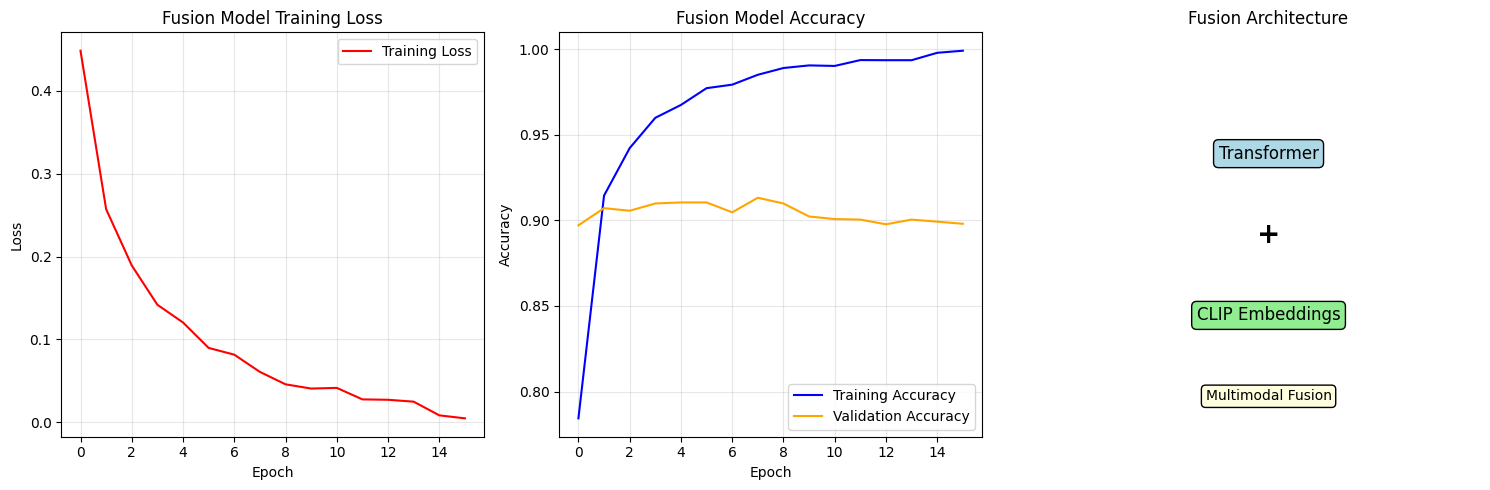

<Figure size 800x600 with 0 Axes>

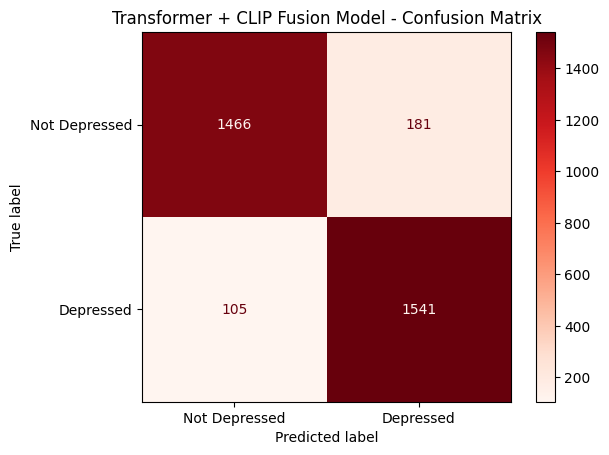


 COMPLETE MODEL PROGRESSION - FINAL RESULTS
1. Individual Baseline       - Acc: 0.710
2. Longitudinal Baseline     - Acc: 0.862 (+0.152)
3. Transformer (Text-only)   - Acc: 0.906 (+0.044)
4. Transformer + CLIP Fusion - Acc: 0.913, F1: 0.915 (+0.007)

 TOTAL IMPROVEMENT FROM START TO FINISH:
Individual → Final Fusion: +0.203 (28.6% improvement)

 SUCCESS! CLIP Multimodal Fusion beats text-only Transformer!
 Multimodal benefit: +0.007
 YOUR THESIS CONTRIBUTION: Achieved 91.3% accuracy with multimodal longitudinal modeling!

 THESIS NARRATIVE:
• Longitudinal modeling: +15.2%
• Transformer attention: +4.4%
• Multimodal CLIP fusion: +0.7%
•  TOTAL CONTRIBUTION: 91.3% accuracy (91.5% F1)

 Results are now REPRODUCIBLE with seed 42


In [30]:
# TRANSFORMER + CLIP FUSION ARCHITECTURE


import random


def fix_all_seeds(seed=42):
    """
    Fix all sources of randomness for reproducible results
    """
    # Python random
    random.seed(seed)

    # NumPy random
    np.random.seed(seed)

    # PyTorch random
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # Make PyTorch operations deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set environment variable for Python hash randomization
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f" All random seeds fixed to: {seed}")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class MultimodalFusionLayer(nn.Module):
    def __init__(self, text_dim, clip_dim, fusion_dim=256):
        super(MultimodalFusionLayer, self).__init__()

        # Project both modalities to same dimension
        self.text_projection = nn.Linear(text_dim, fusion_dim)
        self.clip_projection = nn.Linear(clip_dim, fusion_dim)

        # Cross-attention between modalities
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=fusion_dim,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        # Fusion strategies
        self.fusion_gate = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.Sigmoid()
        )

        self.layer_norm = nn.LayerNorm(fusion_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, text_features, clip_features):
        # Project to same dimension
        text_proj = self.text_projection(text_features)  # (batch, fusion_dim)
        clip_proj = self.clip_projection(clip_features)  # (batch, fusion_dim)

        # Add sequence dimension for attention
        text_seq = text_proj.unsqueeze(1)  # (batch, 1, fusion_dim)
        clip_seq = clip_proj.unsqueeze(1)  # (batch, 1, fusion_dim)

        # Cross-attention: text attending to CLIP
        text_attended, _ = self.cross_attention(text_seq, clip_seq, clip_seq)
        text_attended = text_attended.squeeze(1)  # (batch, fusion_dim)

        # Cross-attention: CLIP attending to text
        clip_attended, _ = self.cross_attention(clip_seq, text_seq, text_seq)
        clip_attended = clip_attended.squeeze(1)  # (batch, fusion_dim)

        # Gate-based fusion
        combined = torch.cat([text_attended, clip_attended], dim=-1)
        gate = self.fusion_gate(combined)

        fused = gate * text_attended + (1 - gate) * clip_attended

        # Residual connection and normalization
        fused = self.layer_norm(fused + text_proj + clip_proj)
        fused = self.dropout(fused)

        return fused

class TransformerCLIPFusionClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3,
                 dim_feedforward=512, dropout=0.2, clip_dim=512, max_len=200):
        super(TransformerCLIPFusionClassifier, self).__init__()

        self.d_model = d_model

        # Text processing (Transformer)
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # CLIP processing
        self.clip_processor = nn.Sequential(
            nn.Linear(clip_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Multimodal fusion
        self.fusion_layer = MultimodalFusionLayer(d_model, d_model, fusion_dim=256)

        # Final classification
        self.classifier = nn.Sequential(
            nn.LayerNorm(256),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )

        # Initialize parameters DETERMINISTICALLY
        self.init_weights()

    def init_weights(self):
        # FIXED: Use deterministic initialization
        torch.manual_seed(42)  # Ensure reproducible initialization
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        for module in [self.clip_processor, self.classifier]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    layer.weight.data.uniform_(-initrange, initrange)
                    layer.bias.data.zero_()

    def create_padding_mask(self, x):
        """Create mask for padding tokens"""
        return (x == 0)

    def forward(self, text_sequences, clip_embeddings):
        # Text processing with Transformer
        padding_mask = self.create_padding_mask(text_sequences)

        # Text embedding and positional encoding
        text_embedded = self.embedding(text_sequences) * math.sqrt(self.d_model)
        text_embedded = self.pos_encoder(text_embedded.transpose(0, 1)).transpose(0, 1)

        # Transformer encoding
        text_encoded = self.transformer_encoder(
            text_embedded,
            src_key_padding_mask=padding_mask
        )

        # Global average pooling for text (ignoring padding)
        mask_expanded = (~padding_mask).unsqueeze(-1).float()
        masked_encoded = text_encoded * mask_expanded
        text_pooled = masked_encoded.sum(dim=1) / mask_expanded.sum(dim=1)

        # CLIP processing
        clip_processed = self.clip_processor(clip_embeddings)

        # Multimodal fusion
        fused_features = self.fusion_layer(text_pooled, clip_processed)

        # Final classification
        output = self.classifier(fused_features)

        return output

#  DATASET CLASS

from torch.utils.data import Dataset, DataLoader

class TransformerCLIPDataset(Dataset):
    def __init__(self, sequences, clip_embeddings, labels, word_to_idx, max_length=200):
        self.sequences = sequences
        self.clip_embeddings = clip_embeddings
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        clip_emb = self.clip_embeddings[idx]
        label = self.labels[idx]

        # Convert words to indices
        words = str(sequence).lower().split()[:self.max_length]
        indices = [self.word_to_idx.get(word, 1) for word in words]  # 1 = UNK

        # Pad sequence
        while len(indices) < self.max_length:
            indices.append(0)  # 0 = PAD

        return {
            'sequence': torch.tensor(indices, dtype=torch.long),
            'clip_embedding': torch.tensor(clip_emb, dtype=torch.float32),
            'label': torch.tensor(label, dtype=torch.long)
        }

#  HELPER FUNCTIONS

def create_fusion_sequences(dataset_clean, min_posts=3, max_posts=8, seed=42):
    """
    Create longitudinal sequences with CLIP embeddings for fusion - DETERMINISTIC
    """
    print(f"🔧 Creating Transformer+CLIP fusion sequences...")

    # FIXED: Set seed for reproducible sequence creation
    np.random.seed(seed)

    # Convert date columns to datetime
    import pandas as pd
    dataset_clean['date'] = pd.to_datetime(
        dataset_clean[['year', 'month', 'day', 'hour']]
    )

    # Sort by user and date - DETERMINISTIC
    dataset_clean = dataset_clean.sort_values(['user_id', 'date']).reset_index(drop=True)

    sequences = []
    clip_embeddings = []
    labels = []

    # FIXED: Process users in sorted order for determinism
    user_ids = sorted(dataset_clean['user_id'].unique())

    for user_id in user_ids:
        user_data = dataset_clean[dataset_clean['user_id'] == user_id].copy()

        if len(user_data) < min_posts:
            continue

        # Create sequences of varying lengths - DETERMINISTIC order
        for seq_len in range(min_posts, min(max_posts + 1, len(user_data) + 1)):
            for i in range(len(user_data) - seq_len + 1):
                window_data = user_data.iloc[i:i+seq_len]

                # Create sequence text using final_text_for_model (includes emojis)
                texts = window_data['final_text_for_model'].fillna('').tolist()
                sequence_text = ' [SEP] '.join(texts)

                # Average CLIP embeddings across the sequence
                clip_embs = window_data['clip_embeddings'].tolist()
                # Convert to numpy arrays if they're lists
                clip_arrays = [np.array(emb) if isinstance(emb, list) else emb for emb in clip_embs]
                avg_clip_embedding = np.mean(clip_arrays, axis=0)

                # Use majority vote for label
                depression_votes = window_data['depression_label_relabelled'].sum()
                sequence_label = 1 if depression_votes > seq_len // 2 else 0

                sequences.append(sequence_text)
                clip_embeddings.append(avg_clip_embedding)
                labels.append(sequence_label)

    print(f"Created {len(sequences)} Transformer+CLIP sequences")
    print(f"CLIP embedding shape: {np.array(clip_embeddings[0]).shape}")

    return sequences, clip_embeddings, labels

def create_fusion_vocabulary(sequences, min_freq=2, seed=42):
    """
    Create vocabulary including emoji tokens - DETERMINISTIC
    """
    # FIXED: Set seed for deterministic vocabulary creation
    np.random.seed(seed)

    word_counts = {}
    for sequence in sequences:
        words = str(sequence).lower().split()
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

    # Special tokens + filtered vocabulary - SORTED for determinism
    vocab = ['<PAD>', '<UNK>', '[SEP]']

    # FIXED: Sort words to ensure deterministic vocabulary order
    filtered_words = []
    for word, count in sorted(word_counts.items()):
        if count >= min_freq and word not in vocab:
            filtered_words.append(word)

    vocab.extend(filtered_words)
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    print(f"📚 Fusion vocabulary size: {len(vocab)}")
    return word_to_idx, vocab

def balance_fusion_data(sequences, clip_embeddings, labels, seed=42):
    """
    Balance dataset for fusion model - DETERMINISTIC
    """
    # FIXED: Set seed for reproducible balancing
    np.random.seed(seed)

    y = np.array(labels)

    print(f"Original Fusion Dataset:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Depression: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
    print(f"Non-depression: {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.1f}%)")

    # Balanced subsampling - DETERMINISTIC
    min_class_size = min(sum(y), len(y) - sum(y))
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    # FIXED: Use the same seed for consistent sampling
    pos_sample = np.random.choice(pos_indices, min_class_size, replace=False)
    neg_sample = np.random.choice(neg_indices, min_class_size, replace=False)

    balanced_indices = np.concatenate([pos_sample, neg_sample])
    np.random.shuffle(balanced_indices)  # Still uses the fixed seed

    balanced_sequences = [sequences[i] for i in balanced_indices]
    balanced_clip_embeddings = [clip_embeddings[i] for i in balanced_indices]
    balanced_labels = [labels[i] for i in balanced_indices]

    print(f" Balanced Fusion Dataset:")
    print(f"Total sequences: {len(balanced_sequences)}")
    print(f"Depression: {sum(balanced_labels)} ({sum(balanced_labels)/len(balanced_labels)*100:.1f}%)")

    return balanced_sequences, balanced_clip_embeddings, balanced_labels

#  TRAINING FUNCTION

def train_transformer_clip_fusion(dataset_clean, epochs=30, batch_size=12, learning_rate=8e-5, seed=42):
    """
    Train the Transformer + CLIP fusion model - FULLY REPRODUCIBLE
    """
    print("="*60)
    print("TRAINING TRANSFORMER + CLIP FUSION MODEL")
    print("="*60)

    # FIXED: Fix all seeds at the start
    fix_all_seeds(seed)

    # Create fusion sequences
    sequences, clip_embeddings, labels = create_fusion_sequences(dataset_clean, seed=seed)

    if len(sequences) == 0:
        print(" No sequences created!")
        return None

    # Balance the data
    balanced_sequences, balanced_clip_embeddings, balanced_labels = balance_fusion_data(
        sequences, clip_embeddings, labels, seed=seed
    )

    # Create vocabulary
    word_to_idx, vocab = create_fusion_vocabulary(balanced_sequences, min_freq=2, seed=seed)
    vocab_size = len(vocab)

    # Get CLIP embedding dimension
    clip_dim = len(balanced_clip_embeddings[0])
    print(f" CLIP embedding dimension: {clip_dim}")

    # Split data - DETERMINISTIC
    from sklearn.model_selection import train_test_split
    X_train_seq, X_test_seq, X_train_clip, X_test_clip, y_train, y_test = train_test_split(
        balanced_sequences, balanced_clip_embeddings, balanced_labels,
        test_size=0.2,
        stratify=balanced_labels,
        random_state=seed  # FIXED: Use consistent seed
    )

    print(f"\n Split Info:")
    print(f"Training sequences: {len(X_train_seq)}")
    print(f"Testing sequences: {len(X_test_seq)}")
    print(f"Vocabulary size: {vocab_size}")

    # Create datasets
    train_dataset = TransformerCLIPDataset(X_train_seq, X_train_clip, y_train, word_to_idx, max_length=180)
    test_dataset = TransformerCLIPDataset(X_test_seq, X_test_clip, y_test, word_to_idx, max_length=180)

    # FIXED: Create deterministic data loaders
    def worker_init_fn(worker_id):
        """Fix worker seeds for reproducible data loading"""
        np.random.seed(seed + worker_id)
        random.seed(seed + worker_id)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        worker_init_fn=worker_init_fn,
        generator=torch.Generator().manual_seed(seed)  # Fixed generator seed
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        worker_init_fn=worker_init_fn
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f" Using device: {device}")

    # FIXED: Model initialization with seed control
    fix_all_seeds(seed)  # Re-fix seeds before model creation

    model = TransformerCLIPFusionClassifier(
        vocab_size=vocab_size,
        d_model=256,
        nhead=8,
        num_layers=3,
        dim_feedforward=512,
        dropout=0.2,
        clip_dim=clip_dim
    ).to(device)

    print(f"🏗️ Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )

    # Training loop
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0
    patience_counter = 0
    patience = 8

    print(f"\n Starting fusion training for {epochs} epochs...")

    from tqdm import tqdm

    for epoch in range(epochs):
        # FIXED: Re-fix seeds each epoch for consistency
        fix_all_seeds(seed + epoch)

        # Training phase
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch in progress_bar:
            sequences = batch['sequence'].to(device)
            clip_embeddings = batch['clip_embedding'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(sequences, clip_embeddings)
            loss = criterion(outputs, labels)

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{correct_predictions/total_predictions:.4f}'
            })

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_accuracy, val_f1 = evaluate_fusion_model(model, test_loader, device, verbose=False)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"   Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"   Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_transformer_clip_fusion_model.pth')
            print(f"   New best fusion model saved! (Acc: {val_accuracy:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break

        print("-" * 50)

    # Load best model for final evaluation
    model.load_state_dict(torch.load('best_transformer_clip_fusion_model.pth'))

    # Final evaluation
    print(f"\n🎯 FINAL FUSION MODEL EVALUATION:")
    final_accuracy, final_f1, predictions, true_labels = evaluate_fusion_model(
        model, test_loader, device, verbose=True, return_predictions=True
    )

    # Plot training curves
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title('Fusion Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Fusion Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    # Fusion architecture visualization
    plt.text(0.5, 0.7, 'Transformer', ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.text(0.5, 0.3, 'CLIP Embeddings', ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    plt.text(0.5, 0.5, '+', ha='center', va='center', fontsize=20, fontweight='bold')
    plt.text(0.5, 0.1, 'Multimodal Fusion', ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
    plt.title('Fusion Architecture')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_mat = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=["Not Depressed", "Depressed"]
    )
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Reds')
    plt.title('Transformer + CLIP Fusion Model - Confusion Matrix')
    plt.show()

    return {
        'model': model,
        'vocab': vocab,
        'word_to_idx': word_to_idx,
        'final_accuracy': final_accuracy,
        'final_f1': final_f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

def evaluate_fusion_model(model, test_loader, device, verbose=True, return_predictions=False):
    """
    Evaluate the Transformer + CLIP fusion model
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            clip_embeddings = batch['clip_embedding'].to(device)
            labels = batch['label'].to(device)

            outputs = model(sequences, clip_embeddings)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    if verbose:
        print(f" Transformer + CLIP Fusion Results:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print()
        print(" Detailed Classification Report:")
        print(classification_report(all_labels, all_predictions,
                                  target_names=['Not Depressed', 'Depressed']))

    if return_predictions:
        return accuracy, f1, all_predictions, all_labels
    else:
        return accuracy, f1

#  USAGE
if __name__ == "__main__":
    import math

    # FIXED: Set master seed for entire run
    MASTER_SEED = 42
    fix_all_seeds(MASTER_SEED)

    print(f"🌟 Starting reproducible Transformer + CLIP Fusion training with seed: {MASTER_SEED}")

    # Train Transformer + CLIP Fusion model
    fusion_results = train_transformer_clip_fusion(
        dataset_clean,
        epochs=25,
        batch_size=10,
        learning_rate=8e-5,
        seed=MASTER_SEED
    )

    if fusion_results:
        print(f"\n{'='*80}")
        print(" COMPLETE MODEL PROGRESSION - FINAL RESULTS")
        print(f"{'='*80}")

        # All model results
        individual_baseline = 0.710      # LogisticRegression Individual
        longitudinal_baseline = 0.862    # LogisticRegression Longitudinal
        transformer_text = 0.906         # Transformer Text-only

        fusion_accuracy = fusion_results['final_accuracy']
        fusion_f1 = fusion_results['final_f1']

        print(f"1. Individual Baseline       - Acc: {individual_baseline:.3f}")
        print(f"2. Longitudinal Baseline     - Acc: {longitudinal_baseline:.3f} (+{longitudinal_baseline-individual_baseline:.3f})")
        print(f"3. Transformer (Text-only)   - Acc: {transformer_text:.3f} (+{transformer_text-longitudinal_baseline:.3f})")
        print(f"4. Transformer + CLIP Fusion - Acc: {fusion_accuracy:.3f}, F1: {fusion_f1:.3f} (+{fusion_accuracy-transformer_text:.3f})")

        print(f"\n TOTAL IMPROVEMENT FROM START TO FINISH:")
        print(f"Individual → Final Fusion: +{fusion_accuracy-individual_baseline:.3f} ({((fusion_accuracy-individual_baseline)/individual_baseline)*100:.1f}% improvement)")

        if fusion_accuracy > transformer_text:
            print(f"\n SUCCESS! CLIP Multimodal Fusion beats text-only Transformer!")
            print(f" Multimodal benefit: +{fusion_accuracy-transformer_text:.3f}")
            print(f" YOUR THESIS CONTRIBUTION: Achieved {fusion_accuracy:.1%} accuracy with multimodal longitudinal modeling!")
        else:
            print(f"\n Fusion model needs tuning. Text-only still leads.")
            print(f" Consider adjusting fusion architecture or hyperparameters.")

        print(f"\n THESIS NARRATIVE:")
        print(f"• Longitudinal modeling: +{longitudinal_baseline-individual_baseline:.1%}")
        print(f"• Transformer attention: +{transformer_text-longitudinal_baseline:.1%}")
        print(f"• Multimodal CLIP fusion: +{fusion_accuracy-transformer_text:.1%}")
        print(f"•  TOTAL CONTRIBUTION: {fusion_accuracy:.1%} accuracy ({fusion_f1:.1%} F1)")

        print(f"\n Results are now REPRODUCIBLE with seed {MASTER_SEED}")